In [9]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
%matplotlib inline

In [10]:
def load_images(directory):
    images = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

In [14]:
def evaluate_transition(img1, img2):
    # Resize images to the same dimensions
    img1_resized = cv2.resize(img1, (min(img1.shape[1], img2.shape[1]), min(img1.shape[0], img2.shape[0])))
    img2_resized = cv2.resize(img2, (min(img1.shape[1], img2.shape[1]), min(img1.shape[0], img2.shape[0])))
    
    # Convert images to grayscale for comparison
    img1_gray = cv2.cvtColor(img1_resized, cv2.COLOR_RGB2GRAY)
    img2_gray = cv2.cvtColor(img2_resized, cv2.COLOR_RGB2GRAY)
    
    # Compute MSE
    mse = np.mean((img1_gray - img2_gray) ** 2)
    
    # Compute SSIM
    ssim, _ = structural_similarity(img1_gray, img2_gray, full=True)
    
    return mse, ssim

In [15]:
preprocessed_directory = "../data/preprocessed"
preprocessed_images = load_images(preprocessed_directory)
print(f"Loaded {len(preprocessed_images)} preprocessed images.")


Loaded 120 preprocessed images.


In [16]:
mse_scores = []
ssim_scores = []

for i in range(len(preprocessed_images) - 1):
    mse, ssim = evaluate_transition(preprocessed_images[i], preprocessed_images[i+1])
    mse_scores.append(mse)
    ssim_scores.append(ssim)

print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average SSIM: {np.mean(ssim_scores):.4f}")

Average MSE: 43.1765
Average SSIM: 0.6194


Text(0, 0.5, 'MSE')

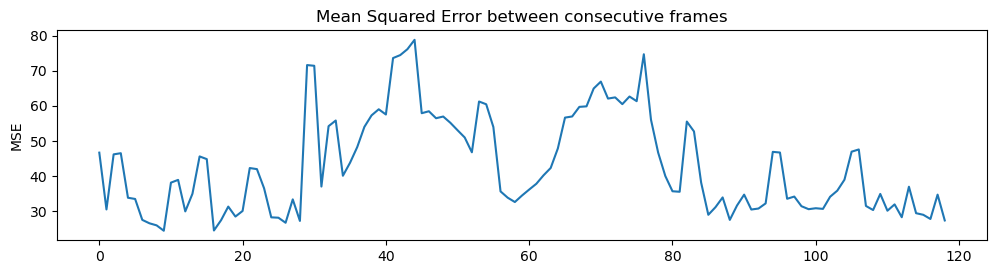

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(mse_scores)
plt.title("Mean Squared Error between consecutive frames")
plt.ylabel("MSE")

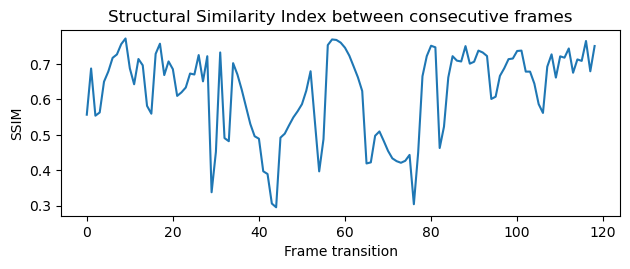

In [20]:
plt.subplot(2, 1, 2)
plt.plot(ssim_scores)
plt.title("Structural Similarity Index between consecutive frames")
plt.ylabel("SSIM")
plt.xlabel("Frame transition")
plt.tight_layout()
plt.show()


In [21]:
threshold_mse = np.mean(mse_scores) + 2 * np.std(mse_scores)
threshold_ssim = np.mean(ssim_scores) - 2 * np.std(ssim_scores)

problematic_transitions = []

for i, (mse, ssim) in enumerate(zip(mse_scores, ssim_scores)):
    if mse > threshold_mse or ssim < threshold_ssim:
        problematic_transitions.append(i)

print(f"Identified {len(problematic_transitions)} problematic transitions:")
print(problematic_transitions)

Identified 7 problematic transitions:
[29, 30, 41, 42, 43, 44, 76]


In [22]:
def plot_transition(img1, img2, mse, ssim, index):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Problematic Transition {index} to {index+1}")
    
    ax1.imshow(img1)
    ax1.set_title(f"Frame {index}")
    ax1.axis('off')
    
    ax2.imshow(img2)
    ax2.set_title(f"Frame {index+1}")
    ax2.axis('off')
    
    plt.text(0.5, -0.1, f"MSE: {mse:.4f}, SSIM: {ssim:.4f}", ha='center', va='center', transform=fig.transFigure)
    plt.tight_layout()
    plt.show()

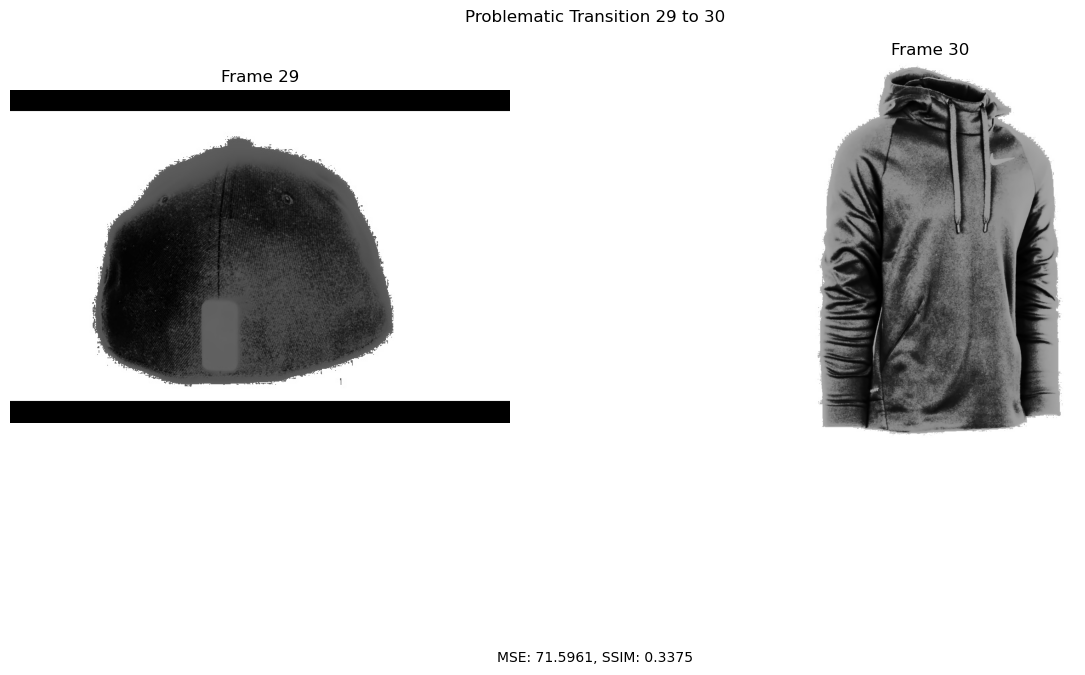

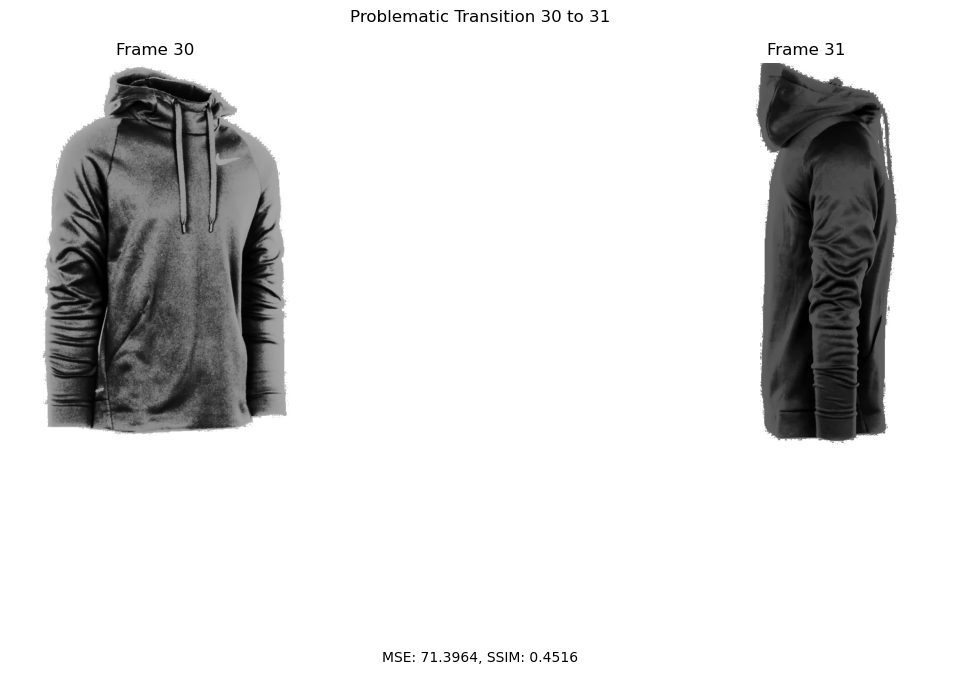

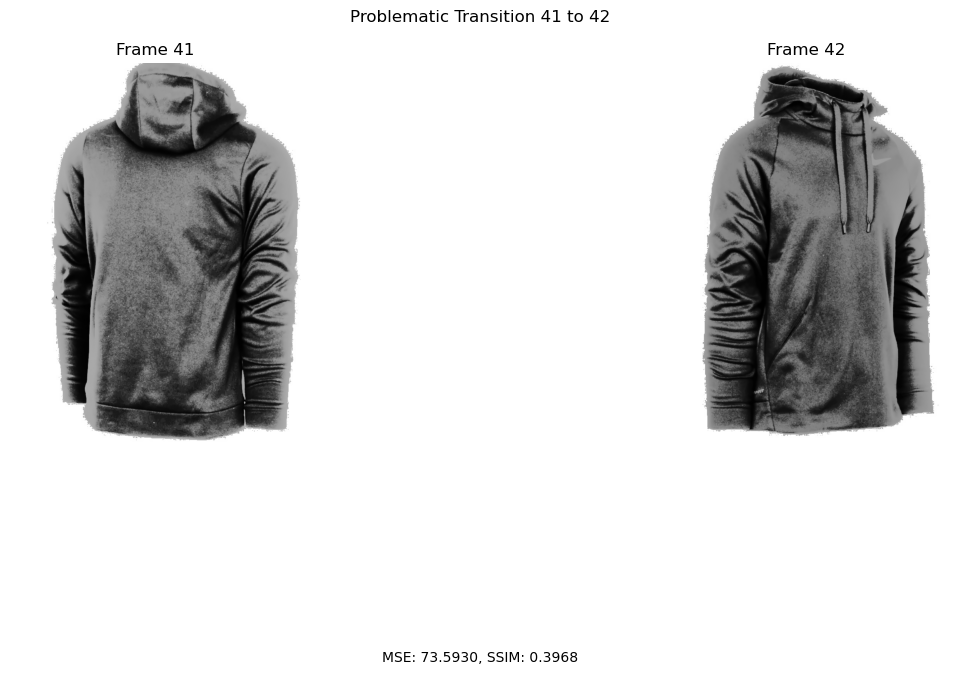

In [23]:
for i in problematic_transitions[:3]:  # Show first 3 problematic transitions
    plot_transition(preprocessed_images[i], preprocessed_images[i+1], mse_scores[i], ssim_scores[i], i)